In [1]:
import numpy as np
import torch
from torch import utils
import pandas as pd
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torch import nn 
from torch.nn import functional as F
import pytorch_lightning as pl
from matplotlib import cm
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from scipy import signal as sig
import os
from pathlib import Path
import re
from torch.utils import data
import random
import pandas as pd
import pickle
import numpy as np
from pathlib import Path
from dataloader import LandmarkDataset, SequenceDataset, LandmarkWaveletDataset
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score, confusion_matrix, accuracy_score

pd.set_option('mode.chained_assignment', None)
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.random.manual_seed(SEED)

find landmark files

In [3]:
data_root = Path('/home/orel/Storage/Data/K7')

landmark_files = list(data_root.glob('2020-*/Down/*DeepCut*.h5'))
landmark_files

[PosixPath('/home/orel/Storage/Data/K7/2020-08-10/Down/0041DeepCut_resnet50_allFeb7shuffle1_1030000.h5'),
 PosixPath('/home/orel/Storage/Data/K7/2020-08-04/Down/0037DeepCut_resnet50_allFeb7shuffle1_1030000.h5'),
 PosixPath('/home/orel/Storage/Data/K7/2020-08-16/Down/0047DeepCut_resnet50_allFeb7shuffle1_1030000.h5'),
 PosixPath('/home/orel/Storage/Data/K7/2020-08-12/Down/0044DeepCut_resnet50_allFeb7shuffle1_1030000.h5'),
 PosixPath('/home/orel/Storage/Data/K7/2020-08-13/Down/0045DeepCut_resnet50_allFeb7shuffle1_1030000.h5'),
 PosixPath('/home/orel/Storage/Data/K7/2020-08-06/Down/0039DeepCut_resnet50_allFeb7shuffle1_1030000.h5'),
 PosixPath('/home/orel/Storage/Data/K7/2020-08-05/Down/0038DeepCut_resnet50_allFeb7shuffle1_1030000.h5')]

# Training the autoencoder

create and train autoencoder model

In [4]:
!nvidia-smi

Sun Apr 25 16:33:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 450.66       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:01:00.0  On |                  N/A |
| 23%   32C    P5    25W / 250W |   1016MiB / 12194MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
class RecurrentEncoder(nn.Module):
    def __init__(self, input_dim, hid_dim, out_dim, n_layers=3):
        super(RecurrentEncoder, self).__init__()
        self.input_dim, self.hid_dim, self.out_dim, self.n_layers = input_dim, hid_dim, out_dim, n_layers
        self.rnn = nn.RNN(input_size=input_dim, hidden_size=hid_dim, num_layers=n_layers, bidirectional=True, batch_first=True)
        self.out_layer = nn.Linear(hid_dim*n_layers*2, out_dim)

    def forward(self, x):
        bs, *_ = x.shape
        outputs, h_n = self.rnn(x)
        output = h_n.view(bs, -1)
        return self.out_layer(output)
        

class RecurrentDecoder(nn.Module):
    def __init__(self, input_dim, hid_dim, out_dim, n_layers):
        super(RecurrentDecoder, self).__init__()
        self.input_dim, self.hid_dim, self.out_dim, self.n_layers = input_dim, hid_dim, out_dim, n_layers
#         self.input_layer = nn.Linear(out_dim, hid_dim*n_layers*2)
        self.rnn = nn.RNN(input_size=input_dim, hidden_size=hid_dim, num_layers=n_layers, bidirectional=True, batch_first=True)
        self.out_layer = nn.Linear(hid_dim*n_layers*2, out_dim)
        
        
# A simple autoencoder
class RecurrentAutoencoder(nn.Module):
    # n_neurons: the sizes of each layer in the encoder - the decoder has the same number of neurons in each layer, in reverse.
    def __init__(self, n_neurons, batch_norm=False, loss_func=None, dropout=0.):
        super(Autoencoder, self).__init__()
        if loss_func:
            self.loss_func = loss_func
        else:
            self.loss_func = F.mse_loss
        self.encoder, self.decoder = get_encoder_decoder(n_neurons, nn.ELU(), dropout=dropout)
        
    def forward(self, x):
        return self.decoder(self.encoder(x))
    
    # computes auto encoding loss for training and evaluation
    def shared_step(self, bx):
        z = self.encoder(bx)
        out = self.decoder(z)
        loss = self.loss_func(bx, out)
        return loss
    
    # encode data to the hidden dimension.
    def encode(self, data, batch_size=256):
        dl = DataLoader(data, batch_size=batch_size, shuffle=False)
        X = []
        self.cuda()
        with torch.no_grad():
            for bx in dl:
                x_encoded = self.encoder(bx.cuda())
                X.append(x_encoded.cpu().numpy())
        X_encoded = np.concatenate(X)
        return X_encoded
        
    # cluster the data using K Means on the encoded data. The data is in the form of SequenceDataset.
    def cluster(self, data, batch_size=256, n_clusters=30):
        X_encoded = self.encode(data, batch_size=batch_size)
        kmeans = KMeans(n_clusters=n_clusters)
        labels = kmeans.fit_predict(X_encoded)
        return labels
    
    
#pytorch-lightning module for training the autoencoder
class PLAutoencoder(pl.LightningModule):
    def __init__(self, , n_neurons, lr, patience=20, batch_norm=False, wd=0.05, dropout=0.0):
        super(PLAutoencoder, self).__init__()
        self.hparams = {'lr': lr, 'patience': patience, 'wd': wd}
        self.model = RecurrentAutoencoder(n_neurons, dropout=dropout)

    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.parameters(), self.hparams['lr'], weight_decay=self.hparams['wd'])
        sched = torch.optim.lr_scheduler.LambdaLR(opt, lambda epoch: 0.9**(epoch//10))
        return [opt], [sched]    
    
    def training_step(self, batch, batch_idx):
        loss = self.model.shared_step(batch)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.model.shared_step(batch)
        self.log('val_loss', loss, prog_bar=True)
        return loss
    


In [6]:
# from simple_autoencoder import Autoencoder, PLAutoencoder
from dataloader import LandmarksDataModule
seqlen = 60
n_parts = 19
dm = LandmarksDataModule(landmark_files, seqlen=seqlen, step=3)
model = PLAutoencoder(landmark_files, n_neurons=[2*n_parts*seqlen, 1024, 512, 30], lr=3e-4, patience=20, dropout=0.0)
trainer = pl.Trainer(gpus=1, progress_bar_refresh_rate=10, max_epochs=20, logger=pl.loggers.WandbLogger("landmarks autoencoder"), log_every_n_steps=1)
# trainer.fit(model)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [7]:
trainer.fit(model, dm)

wandb: Currently logged in as: shukistern (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name  | Type        | Params
--------------------------------------
0 | model | Autoencoder | 5.8 M 
--------------------------------------
5.8 M     Trainable params
0         Non-trainable params
5.8 M     Total params
/home/shuki/anaconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

/home/shuki/anaconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/shuki/anaconda3/envs/torch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

In [ ]:
# torch.load(' models/11_03/model.pt')
# model.load_state_dict(torch.load('models/11_03/model.pt'))

In [8]:
model_dir = Path('models/04_27_1')
os.makedirs(model_dir, exist_ok=True)
torch.save(model.state_dict(), model_dir / 'model.pt')

In [91]:
# from simple_autoencoder import Autoencoder, PLAutoencoder
# from dataloader import LandmarksDataModule
# seqlen = 60
# n_parts = 19
# dm = LandmarksDataModule(landmark_files, seqlen=seqlen, step=3)
# model = PLAutoencoder(landmark_files, n_neurons=[2*n_parts*seqlen, 1024, 512, 5], lr=3e-4, seqlen=seqlen, patience=20)
# trainer = pl.Trainer(gpus=1, progress_bar_refresh_rate=10, max_epochs=30, logger=pl.loggers.WandbLogger("landmarks autoencoder"))
# trainer.fit(model, dm)

# model_dir = Path('models/04_26_2')
# os.makedirs(model_dir, exist_ok=True)
# torch.save(model.state_dict(), model_dir / 'model.pt')

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | Autoencoder | 5.7 M 
--------------------------------------
5.7 M     Trainable params
0         Non-trainable params
5.7 M     Total params
/home/shuki/anaconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

/home/shuki/anaconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/shuki/anaconda3/envs/torch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [8]:
from torch.utils.data import Dataset, ConcatDataset, Subset
import bisect

def find_sub_dataset(ds: ConcatDataset, idx):
    dataset_idx = bisect.bisect_right(ds.cumulative_sizes, idx)
    if dataset_idx == 0:
        sample_idx = idx
    else:
        sample_idx = idx - ds.cumulative_sizes[dataset_idx - 1]
    return ds.datasets[dataset_idx], sample_idx

def find_frame(ds, idx):
    ds, idx = find_sub_dataset(ds, idx)
    if isinstance(ds, Subset):
        ds, idx = ds.dataset, ds.indices[idx]
    ds, idx = find_sub_dataset(ds, idx)
    video_file = ds.data_frame.attrs['video_file']
    frame_idxs = ds.get_indexes(idx)
    return video_file, frame_idxs


from scipy import signal as sig
energies = np.zeros(len(dm.all_ds))
for i, item in enumerate(dm.all_ds):
    item = item.reshape((dm.seqlen, -1))
    ff, Pxx = sig.periodogram(item.T, fs=dm.fps)
    energies[i] = Pxx.T[:10].mean()
    


60

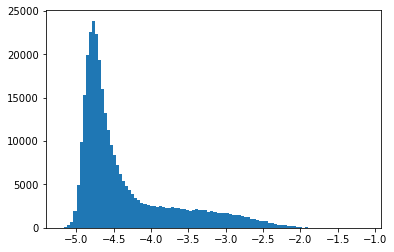

In [9]:
plt.hist(np.log10(energies), bins=100)
dm.seqlen

In [15]:
np.where(energies > 5e-3)[0][643]

98481

In [31]:
dm.data_frames[0].columns.levels[0]

Index(['belly1', 'belly2', 'chest1', 'chest2', 'forePawL1', 'forePawL2',
       'forepawR1', 'forepawR2', 'head', 'hindpawL1', 'hindpawL2', 'hindpawL3',
       'hindpawR1', 'hindpawR2', 'hindpawR3', 'nose', 'tail1', 'tail3',
       'tailbase'],
      dtype='object')

compare the original and reconstructed data, each plot for a different feature / coordinate

No handles with labels found to put in legend.


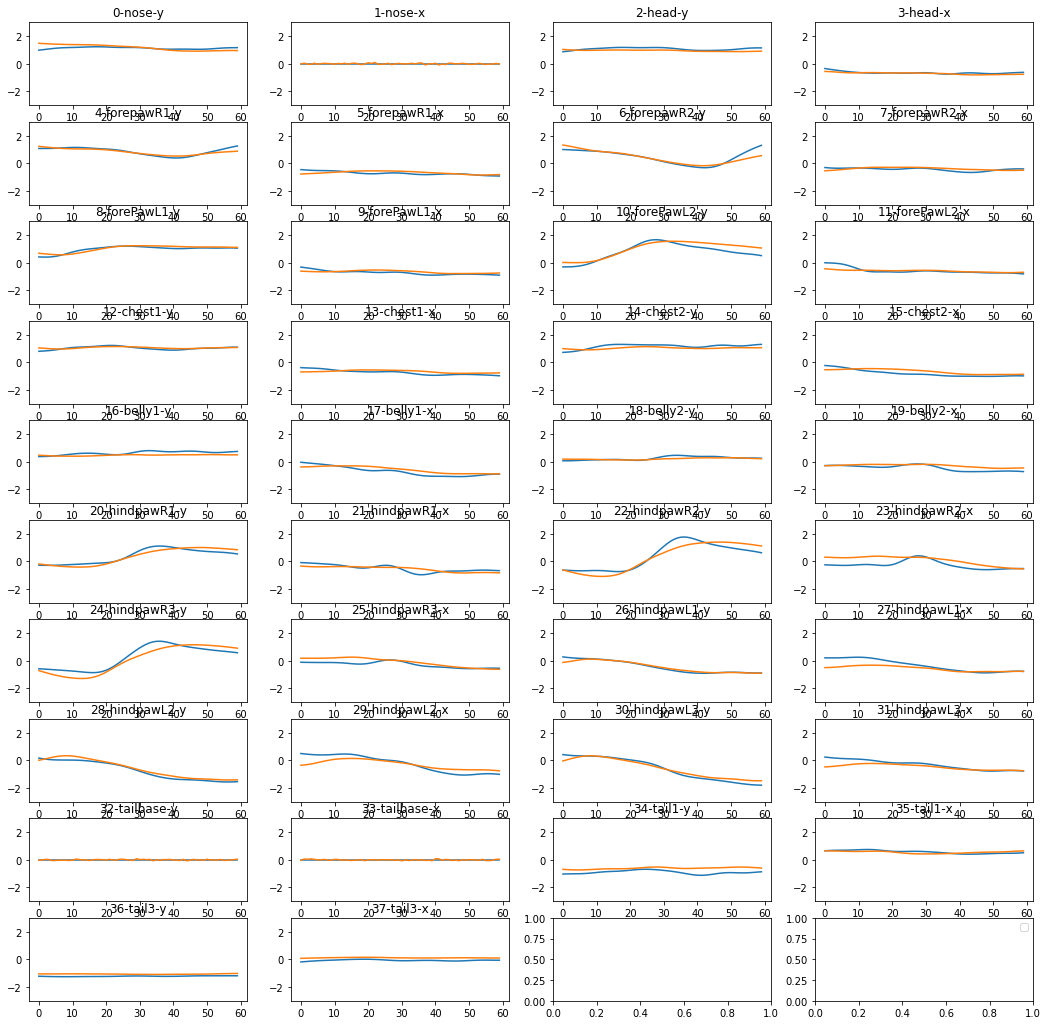

In [16]:
body_parts = dm.data_frames[0].columns.levels[0]
def compare_plot(x, y):
    x = x.reshape(-1, n_parts*2)
    y = y.reshape(-1, n_parts*2)
    fig, axes = plt.subplots(ncols=4, nrows=n_parts//2+1, figsize=(18, 18))
    for i in range(n_parts//2+1):
        for j in range(4):
            idx = 4*i + j
            if idx >= x.shape[1]: break
            axes[i][j].plot(x[:,idx], label='orig')
            axes[i][j].plot(y[:,idx], label='recon')
            axes[i][j].set_title(f"{idx}-{body_parts[idx//2]}-{'x' if idx%2 else 'y'}")
            axes[i][j].set_ylim(-3, 3)
    plt.legend()

idx = 98481
with torch.no_grad():
#     bx = next(iter(model.train_dataloader()))
    bx = torch.Tensor(dm.all_ds[idx])[None]
    out = model(bx)
compare_plot(bx[0].cpu().numpy(), out[0].cpu().numpy())

In [54]:
def find_dataset_idx(ds: ConcatDataset, idx):
    dataset_idx = bisect.bisect_right(ds.cumulative_sizes, idx)
    if dataset_idx == 0:
        sample_idx = idx
    else:
        sample_idx = idx - ds.cumulative_sizes[dataset_idx - 1]
    return dataset_idx, sample_idx


ds_id, _id = find_dataset_idx(dm.all_ds, idx)
# ds, _id = find_sub_dataset(dm.all_ds.datasets[ds_id], _id)
dm.data_frames[ds_id].loc[frames].tail3

,x,y
index,,
90230,0.891732,1.991624
90231,0.892166,1.991499
90232,0.892643,1.991502
90233,0.893072,1.991606
90234,0.893322,1.991777
90235,0.893246,1.991979
90236,0.892733,1.992176
90237,0.891783,1.992341
90238,0.890578,1.992459


In [51]:
from torch.utils.data import Dataset, ConcatDataset, Subset
dm.all_ds.datasets[0].datasets[0].data_frame.attrs
import bisect

def find_sub_dataset(ds: ConcatDataset, idx):
    dataset_idx = bisect.bisect_right(ds.cumulative_sizes, idx)
    if dataset_idx == 0:
        sample_idx = idx
    else:
        sample_idx = idx - ds.cumulative_sizes[dataset_idx - 1]
    return ds.datasets[dataset_idx], sample_idx

def find_frame(ds, idx):
    ds, idx = find_sub_dataset(ds, idx)
    if isinstance(ds, Subset):
        ds, idx = ds.dataset, ds.indices[idx]
    ds, idx = find_sub_dataset(ds, idx)
    video_file = ds.data_frame.attrs['video_file']
    frame_idxs = ds.get_indexes(idx)
    return video_file, frame_idxs

video_file, frames = find_frame(dm.all_ds, idx)

# Clustering the data

loading the landmark coordinates from all videos

In [ ]:
landmark_datasets = []
for file in landmark_files:
    try:
        ds = LandmarkDataset(file)
        landmark_datasets.append(ds)
        break
    except OSError:
        pass
# coords = [sig.decimate(ds.coords, q=4, axis=0).astype(np.float32) for ds in landmark_datasets]
coords = model.coords

In [66]:
model.model.encoder[-1].out_features

10

In [67]:
# all_data = np.stack([dm.all_ds[i] for i in range(len(dm.all_ds))])
X_encoded = model.model.encode(dm.all_ds)

K = model.model.encoder[-1].out_features
kmeans = KMeans(K)
labels = kmeans.fit_predict(X_encoded)


1

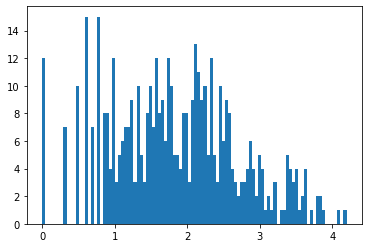

In [76]:
from collections import Counter

def split_labels(labels):
    split_at = np.where(np.diff(labels) != 0)[0] + 1
    sequence = [[seg[0], split_at[i-1] + model.seqlen//2, len(seg)] \
                for i, seg in enumerate(np.split(labels, indices_or_sections=split_at))]
    sequence[0][1] = model.seqlen//2
    return sequence

segments = split_labels(labels)
plt.hist([np.log10(seg[-1]) for seg in segments], bins=100)
1

creating the dataset from all the coordinates